## Download Datasets, Load And Convert

In [1]:
import urllib3
import os
import numpy as np
import pandas as pd
import pickle
import logging
import warnings
import matplotlib.pyplot as plt

In [2]:
def download_dataset(url, save_directory, save_filename): 
    
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Download the dataset
    http = urllib3.PoolManager()
    response = http.request(method='GET', url=url)
    if response.status == 200:
        save_path = os.path.join(save_directory, save_filename + '.tar.gz')
        with open(save_path, 'wb') as file:
            file.write(response.data)
        logging.debug("Dataset downloaded successfully.")
        return save_path
    else:
        logging.debug("Failed to download the dataset.")  
        raise Exception("Failed to download the dataset.")

In [3]:
def extract_from_zip(zip_path, directory_name):
    import tarfile
    with tarfile.open(zip_path, 'r:gz') as tar:
        tar.extractall(directory_name)
        created_directory = tar.getnames()[0].split('/')[0]
    extracted_directory = os.path.join(directory_name, created_directory)
    return extracted_directory

In [4]:
def load_CIFAR_10_dataset(extracted_directory):
   
    # Load label names from metadata
    label_names_file = os.path.join(extracted_directory, 'batches.meta')
    with open(label_names_file, 'rb') as file:
        label_names_dict = pickle.load(file, encoding='bytes')
        label_names = [label.decode('utf-8') for label in label_names_dict[b'label_names']]
        
    data = []
    labels = []
    
    # Load data batches
    for i in range(1, 6):
        batch_file = os.path.join(extracted_directory, 'data_batch_{}'.format(i))
        with open(batch_file, 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
        data.append(data_dict['data'])
        labels.extend(data_dict['labels'])
    
    # load test batch
    batch_file = os.path.join(extracted_directory, 'test_batch')
    with open(batch_file, 'rb') as file:
        data_dict = pickle.load(file, encoding='latin1')
    data.append(data_dict['data'])
    labels.extend(data_dict['labels'])
        
    data = np.concatenate(data, axis=0)
    labels = np.array(labels)
    
    data = data.reshape(60000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    labels = np.array(labels)

    return data.reshape(60000,-1), labels, label_names

In [5]:
def load_CIFAR_100_dataset(extracted_directory):
    def unpickle(file):
        with open(file, 'rb') as fo:
            data_dict = pickle.load(fo, encoding='latin1')
        return data_dict

    file = os.path.join(extracted_directory, 'train')
    test_file = os.path.join(extracted_directory, 'test')
    meta_file = os.path.join(extracted_directory, 'meta')

    # Load training data
    dict = unpickle(file)
    data = dict['data'].reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    labels = np.array(dict['coarse_labels'])

    # Load test data
    test_dict = unpickle(test_file)
    test_data = test_dict['data'].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    test_labels = np.array(test_dict['coarse_labels'])
    
    # Load meta data
    meta_dict = unpickle(meta_file)
    label_names = meta_dict['coarse_label_names']
    
    data_100 = np.concatenate((data, test_data),axis = 0)
    labels_100 = np.concatenate((labels, test_labels),axis = 0)
    
    return data_100.reshape(60000, -1), labels_100, label_names

In [6]:
def convert_to_csv(save_directory, data, labels,label_names,save_filename, save_filename_names):
    csv_data = np.concatenate((data, labels[:, np.newaxis]), axis=1)
    csv_columns = ['pixel_{}'.format(i) for i in range(data.shape[1])] + ['label']

    csv_df = pd.DataFrame(csv_data, columns=csv_columns)
    csv_df_names = pd.DataFrame(np.array(label_names), columns=["coarse_label_names"])
    # Create the data folder if it doesn't exist
    data_folder = os.path.join(save_directory, 'data')
    os.makedirs(data_folder, exist_ok=True)
    
    csv_save_path = os.path.join(data_folder, save_filename)
    csv_df.to_csv(csv_save_path, index=False)
    
    csv_save_path_names = os.path.join(data_folder, save_filename_names)
    csv_df_names.to_csv(csv_save_path_names, index=False)
    logging.debug("CIFAR-10 dataset converted to CSV successfully.")
    
    return csv_save_path,csv_save_path_names

In [7]:
def dataset_preparations():
    
    # constants
    url_10 = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    url_100 = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    save_directory = "C://Users//win//Bsd_Bootcamp//Project"  
    save_filename_10 = 'CIFAR-10_dataset.csv'  
    save_filename_100 = 'CIFAR-100_dataset.csv'
    save_filename_names_10 = 'CIFAR-10_names.csv'  
    save_filename_names_100 = 'CIFAR-100_names.csv'

    ### download datasets
    path_10 = download_dataset(url_10, save_directory, save_filename_10)
    path_100 = download_dataset(url_100, save_directory, save_filename_100)
    
    ### Extract the zipeed directories
    extracted_directory_10 = extract_from_zip(path_10, save_directory)
    extracted_directory_100 = extract_from_zip(path_100, save_directory)
        
    ### Load datasets
    data_10, labels_10, label_names_10 = load_CIFAR_10_dataset(extracted_directory_10)
    data_100, labels_100, label_names_100 = load_CIFAR_100_dataset(extracted_directory_100)
    
    ### Convert datasets to csv format
    data_10_csv, names_10_csv = convert_to_csv(save_directory, data_10, labels_10, label_names_10, save_filename_10, save_filename_names_10)
    data_100_csv, names_100_csv = convert_to_csv(save_directory, data_100, labels_100, label_names_100, save_filename_100, save_filename_names_100)
    
    return data_10_csv, names_10_csv, data_100_csv, names_100_csv


### Test that conversion is correct 

In [8]:
def test_convert_and_load(file_path:str):
    import random
    df_dataset = pd.read_csv(file_path)
    df_pixels = df_dataset[filter(lambda x: x.startswith('pixel') == True, df_dataset.columns)]
    fig, ax = plt.subplots(figsize=(1,1))
    ax.imshow(np.array(df_pixels.iloc[random.choice(range(df_pixels.shape[0]))]).reshape(32,32,3))

In [9]:
def test_dataset_preparations():
    cifar_10_csv_path, names_10_csv, cifar_100_csv_path, names_100_csv = dataset_preparations()
    test_convert_and_load(cifar_10_csv_path)
    test_convert_and_load(cifar_100_csv_path)

### Download Dataset & Convert (csv format)

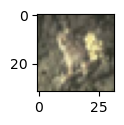

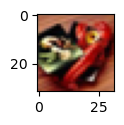

In [10]:
test_dataset_preparations()

## Add Super Classes From CIFAR-100 To CIFAR-10

In [11]:
import os
import pandas as pd
import pickle

In [12]:
def super_class_from_local_CIFAR_100(label_name:str, cifar100_path: str) -> pd.DataFrame:
    
    # Extract directory name
    directory = os.path.dirname(cifar100_path)
    meta_path = os.path.join(directory, 'CIFAR-100_names.csv')
    
    # Read labels names
    df_labels_names = pd.read_csv(meta_path)
    
    # Read CIFAR-100 dataset
    df_cifar_100 = pd.read_csv(cifar100_path)
    
    label = df_labels_names.index[df_labels_names['coarse_label_names'] == label_name].tolist()[0]
    df = pd.DataFrame(df_cifar_100.loc[df_cifar_100['label'] == label])
    return df

In [13]:
def add_super_classes_from_local_CIFAR_100(labels_names: list, cifar100_path:str, from_label:int) -> pd.DataFrame:
    
    # Extract directory name
    dir_name = os.path.dirname(cifar100_path)
    cifar_10_names_path = os.path.join(dir_name, 'CIFAR-10_names.csv')
    
    # Read CIFAR-10 Labels names
    df_names = pd.read_csv(cifar_10_names_path)
    
    dfd = None

    for label_name, label_index in zip(labels_names, range(from_label, from_label + len(labels_names))):
        df = super_class_from_local_CIFAR_100(label_name, cifar100_path)
        label = df.iloc[0]['label']
        # replace CIFAR-100 label to a proper label 
        df['label'] = df['label'].replace(label, label_index)
        
        ### store the new labels
        df_new_label_name = pd.DataFrame([label_name], index=[label_index], columns=df_names.columns)
        df_names = pd.concat([df_names, df_new_label_name])
        df_names.to_csv(os.path.join(dir_name, 'dataset_names.csv'))
        
        # initialize the dataframe or concatenate
        if type(dfd) != pd.core.frame.DataFrame:
            dfd = df
        else:
            dfd = pd.concat([dfd, df])
    # return a single dataframe object of all required labels images from CIFAR-100
    return dfd

In [14]:
def add_super_classes_from_local_CIFAR_100_to_CIFAR_10(cifar10_path:str, cifar100_path:str, labels_names:list) -> pd.DataFrame:
    
    df_super_classes = add_super_classes_from_local_CIFAR_100(labels_names, cifar100_path, 10)
    df_cifar_10 = pd.read_csv(cifar10_path)
    
    # Add what is the origin of data
    df_super_classes["source"] = "cifar-100"
    df_cifar_10["source"] = "cifar-10"
    
    # concatenate 
    df_dataset = pd.concat([df_cifar_10, df_super_classes])
    # shuffle df
    # df_cifar_10.sample(frac=1)
    
    # Save the combined dataframe of CIFAR-10 with required labels images of CIFAR-100
    df_dataset.to_csv('./data/dataset.csv')
    
    return df_dataset

In [15]:
def combine_datasets():
    
    # constants
    cifar10 = './data/CIFAR-10_dataset.csv'
    cifar100 = './data/CIFAR-100_dataset.csv'
    labels_names = ['people', 'flowers', 'trees']

    df_dataset = add_super_classes_from_local_CIFAR_100_to_CIFAR_10(cifar10, cifar100, labels_names)
    return df_dataset

In [16]:
df_dataset = combine_datasets()

## Analyze Merged Dataset - how many images in each class after the merge of DB

In [17]:
def show_images_ammont_per_class(df_dataset: pd.DataFrame):
    df_dataset['label'].value_counts().plot.bar()

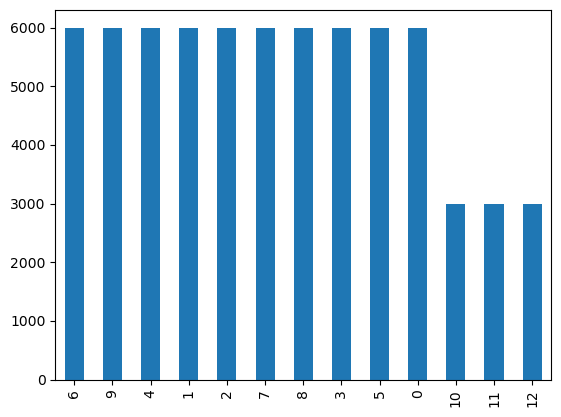

In [18]:
show_images_ammont_per_class(df_dataset)

### Test Images From CIFAR-100 InCombined Dataset

In [19]:
def test_cifar100_images():
    import random
    ind = random.choice([i for i in range(60000, df_dataset.shape[0])])
    pixels = df_dataset[filter(lambda x: x.startswith('pixel') == True, df_dataset.columns)]
    im = pixels.iloc[ind]
    fig, ax = plt.subplots(figsize=(1,1))
    ax.imshow(np.array(im).reshape(32,32,3))

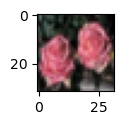

In [20]:
test_cifar100_images()

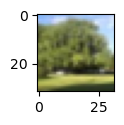

In [21]:
test_cifar100_images()

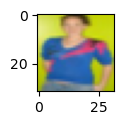

In [22]:
test_cifar100_images()

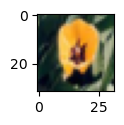

In [23]:
test_cifar100_images()

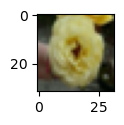

In [24]:
test_cifar100_images()

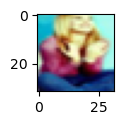

In [25]:
test_cifar100_images()

# TO DO:
## Add more test data: capture your own images (of toys or some objects similar to those in the set) and bring to the format of CIFAR-10!